In [14]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

In [15]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [16]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [17]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    
    # residual
    r =  s - (D @ x)
    
    # support set
    omega = []
    
    while np.linalg.norm(r) > tau and np.count_nonzero(x) < L:

        # SWEEP STEP: look for the column of D that matches at best noisySignal
        # compute the residual w.r.t. each column of D
        e = np.zeros(N)
        for j in range(N):
            dj = D[:,j]
            zj = ((r.T @ dj) / np.linalg.norm(dj))**2
            e[j] = np.linalg.norm(r)**2 - zj

        # find the column of D that matches at best r
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
        # this makes sense but it makes the graph soften the spikes because it's not using all the points
        # if jStar not in omega: # because omega is a set
        #     omega.append(jStar) # this also guarantees to obtain a singular matrix

        # update the coefficients by solving the least square problem min ||D_omega x - s ||
        D_omega = D[:,omega]
        l_term = np.linalg.inv(D_omega.T @ D_omega)
        r_term = D_omega.T @ s
        x_omega = l_term @ r_term

        x[omega] = x_omega

        # update the residual
        r = s - (D @ x)

    return x

Load the image and rescale it in $[0,1]$

In [18]:
img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [19]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [20]:
mse = np.mean((img-noisy_img)**2)
psnr_noisy = 10*np.log10(1/mse)
psnr_noisy

np.float64(22.105565688426083)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.11')

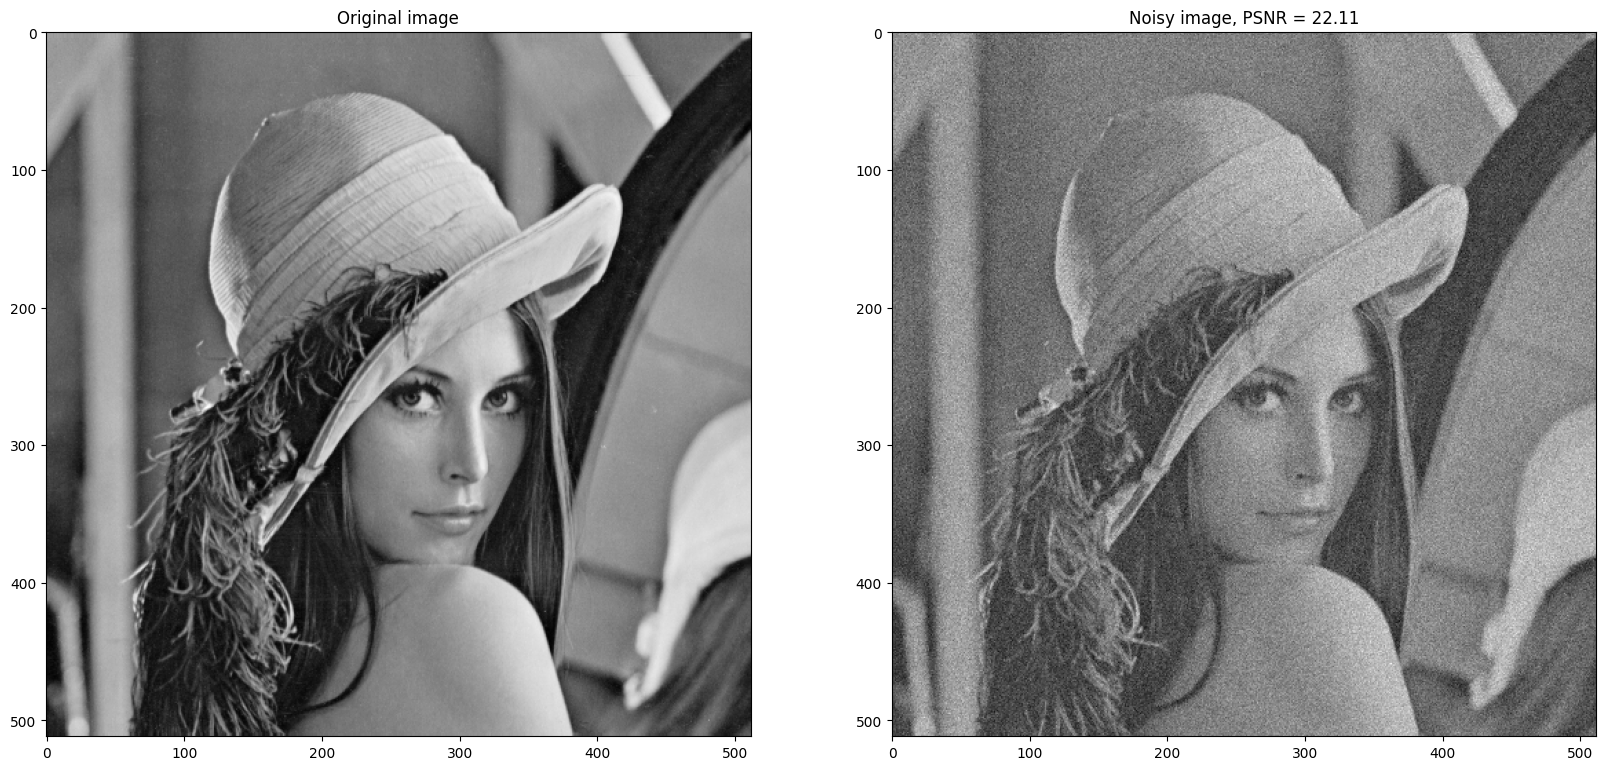

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Load and display the dictionary learned from patches

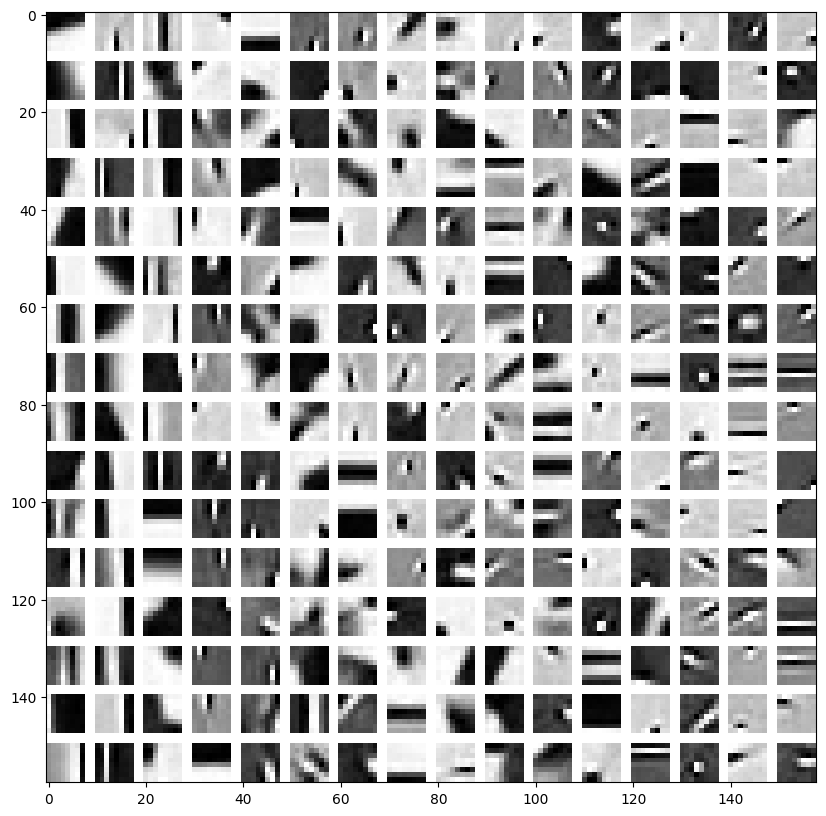

In [22]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# display the dct basis
plt.figure(figsize=(10,10))
plt.imshow(get_dictionary_img(D), cmap='gray')

Denoising
---------


In [23]:
# initialize the estimated image
img_hat = np.zeros_like(noisy_img)

# initialize the weight matrix
weights = np.zeros_like(noisy_img)

# set the threshold
tau = 1.15 * p * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

L = 4

Operate patchwise

In [24]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p]

        # store and subtract the mean
        avg = np.mean(s)
        s_sub = (s - avg).reshape(-1)

        # perform the sparse coding
        x = OMP(s_sub, D, L, tau)

        # perform the reconstruction
        s_hat = D @ x

        # add back the mean
        s_hat = s_hat + avg

        # put the denoised patch into the estimated image using uniform weights
        w = 1 # uniform weights
        img_hat[i:i+p, j:j+p] += s_hat.reshape((p, p)) * w

        # store the weight of the current patch in the weight matrix
        weights[i:i+p, j:j+p] += w


Normalize the estimated image with the computed weights

In [25]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 31.00')

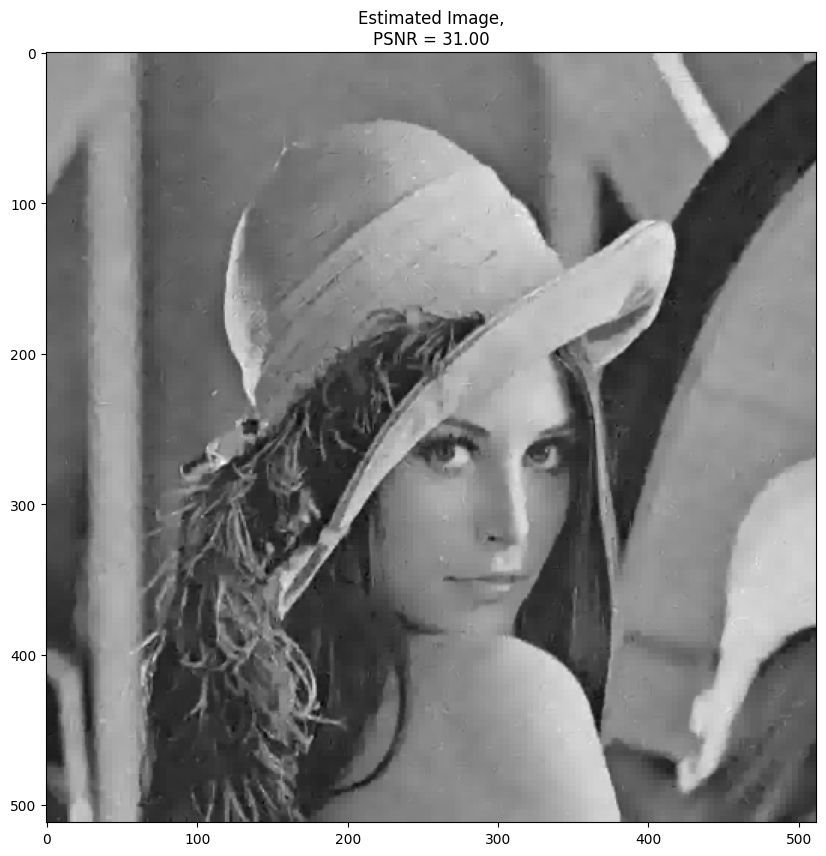

In [26]:
mse = np.mean((img-img_hat)**2)
psnr_hat = 10*np.log10(1/mse)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')